<a href="https://colab.research.google.com/github/WillyC7/ProgettoDataIntensive/blob/main/Progetto_Carletti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determinare il prezzo di un automobile usata

**Progetto finale Programmazione di Applicazioni Data Intensive**

Creato da: Carletti William


## Parte 1a - Descrizione del problema

Lo scopo di questo progetto è quello di creare un modello capace di predire il prezzo di vendita di un'automobile usata in base ai dati relativi alle auto attualmente presenti sul mercato.
Il progetto considererà solo le auto usate di uno specifico brand (Mercedes), presenti nel mercato inglese.

###Caricamento dei dati:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [ ]:
data = pd.read_csv("merc.csv",)
data["price"] = data["price"].astype("float64")
data

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,SLK,2005,5200.0,Automatic,63000,Petrol,325,32.1,1.8
1,S Class,2017,34948.0,Automatic,27000,Hybrid,20,61.4,2.1
2,SL CLASS,2016,49948.0,Automatic,6200,Petrol,555,28.0,5.5
3,G Class,2016,61948.0,Automatic,16000,Petrol,325,30.4,4.0
4,G Class,2016,73948.0,Automatic,4000,Petrol,325,30.1,4.0
...,...,...,...,...,...,...,...,...,...
13114,C Class,2020,35999.0,Automatic,500,Diesel,145,55.4,2.0
13115,B Class,2020,24699.0,Automatic,2500,Diesel,145,55.4,2.0
13116,GLC Class,2019,30999.0,Automatic,11612,Diesel,145,41.5,2.1
13117,CLS Class,2019,37990.0,Automatic,2426,Diesel,145,45.6,2.0


Il numero totale di record si attesta a 13119, con 9 feature.
Di seguito trovamo l'occupazione di memoria del dataset grezzo.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13119 entries, 0 to 13118
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         13119 non-null  object 
 1   year          13119 non-null  int64  
 2   price         13119 non-null  float64
 3   transmission  13119 non-null  object 
 4   mileage       13119 non-null  int64  
 5   fuelType      13119 non-null  object 
 6   tax           13119 non-null  int64  
 7   mpg           13119 non-null  float64
 8   engineSize    13119 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 922.6+ KB


###Significato dei dati:

Le feature del dataset sono le seguenti:


####Dati categorici
*   model : il modello di auto;
*   transmission: il tipo di trasmissione;
*   fuelType: il carburante utilizzato.

####Dati numerici
*   year: anno di immatricolazione del mezzo;
*   mileage: le miglia totali percorse;
*   tax: tassa annuale (in sterline);
*   mpg: miglia percorse con un gallone di carburante;
*   engineSize: dimensioni del motore, indicato come i litri di carburante e aria che esso è in grado di iniettare nei cilindri;
*   price: prezzo (in sterline) a cui viene proposta l'automobile.

Quest'ultima rappresenta anche la variabile di cui vogliamo predire il valore. Essa è continua, dunque ci troviamo davanti ad un problema di regressione.



Per ottimizzare l'occupazione in memoria, benchè il numero di righe non sia molto elevato, si convertono le feature model, transmission e fuelType da tipo object a category.

In [ ]:
categoric_features = ["model","transmission","fuelType"];
numeric_features = ["year","price","mileage","tax","mpg","engineSize"];

In [ ]:
for feature in categoric_features:
    data[feature] = data[feature].astype("category")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13119 entries, 0 to 13118
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   model         13119 non-null  category
 1   year          13119 non-null  int64   
 2   price         13119 non-null  float64 
 3   transmission  13119 non-null  category
 4   mileage       13119 non-null  int64   
 5   fuelType      13119 non-null  category
 6   tax           13119 non-null  int64   
 7   mpg           13119 non-null  float64 
 8   engineSize    13119 non-null  float64 
dtypes: category(3), float64(3), int64(3)
memory usage: 655.3 KB


###Pulizia dati
Per prima cosa, andiamo a controllare l'eventuale presenza di record nulli.

In [ ]:
data.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

Come possiamo notare, nessuna feature presenta valori nulli.
In seguito, andiamo ad ricavare da year la feature **age**, ossia l'età della macchina. Questa feature risulta essere più accurata di year in quanto è indipendente dall'anno in cui ci troviamo, perciò sostituirà year. Tale operazione viene fatta considerando l'anno in cui sono stati rilevati i dati, ossia il 2020. 

In [ ]:
data["age"] = 2020 - data["year"];
data.drop(columns="year",inplace=True);
numeric_features.append("age");
numeric_features.remove("year");

##Parte 1b - Analisi esplorativa

Per prima cosa andiamo ad osservare le caratteristiche di base delle sole feature numeriche appartenenti ai dati analizzati.

In [ ]:
data.describe()

,price,mileage,tax,mpg,engineSize,age
count,13119.000000,13119.000000,13119.000000,13119.000000,13119.000000,13119.000000
mean,24698.596920,21949.559037,129.972178,55.155843,2.071530,2.703712
std,11842.675542,21176.512267,65.260286,15.220082,0.572426,2.224709
min,650.000000,1.000000,0.000000,1.100000,0.000000,0.000000
25%,17450.000000,6097.500000,125.000000,45.600000,1.800000,1.000000
50%,22480.000000,15189.000000,145.000000,56.500000,2.000000,2.000000
75%,28980.000000,31779.500000,145.000000,64.200000,2.100000,4.000000
max,159999.000000,259000.000000,580.000000,217.300000,6.200000,50.000000


Come possiamo vedere, le auto analizzate in media sono state immatricolate nell'anno **2017**, solo il 25% di esse risalgono ad un anno precedente al **2016**.
Il prezzo medio si aggira sulle **21000** sterline, appropriato se si considera la fama del marchio automobilistico.
Osservando i dati relativi alle miglia percorsa dai veicoli, invece, ci accorgiamo che il 75% di essi non supera le **32000** miglia (~52000 chilometri), dato sicuramente influenzato dall'età media delle auto.
Passando al costo della tassa di registrazione del mezzo, notiamo che il prezzo medio si attesta sulle **130** £, ma la deviazione standard del dato risulta essere anch'essa elevata: controllando la tassazione effettuata nel Regno Unito, scopriamo che il prezzo deriva dalle emissioni di CO2 prodotte dal veicolo.
###TODO

Per vedere meglio questi dati, ci affidiamo alle rappresentazioni boxplot.

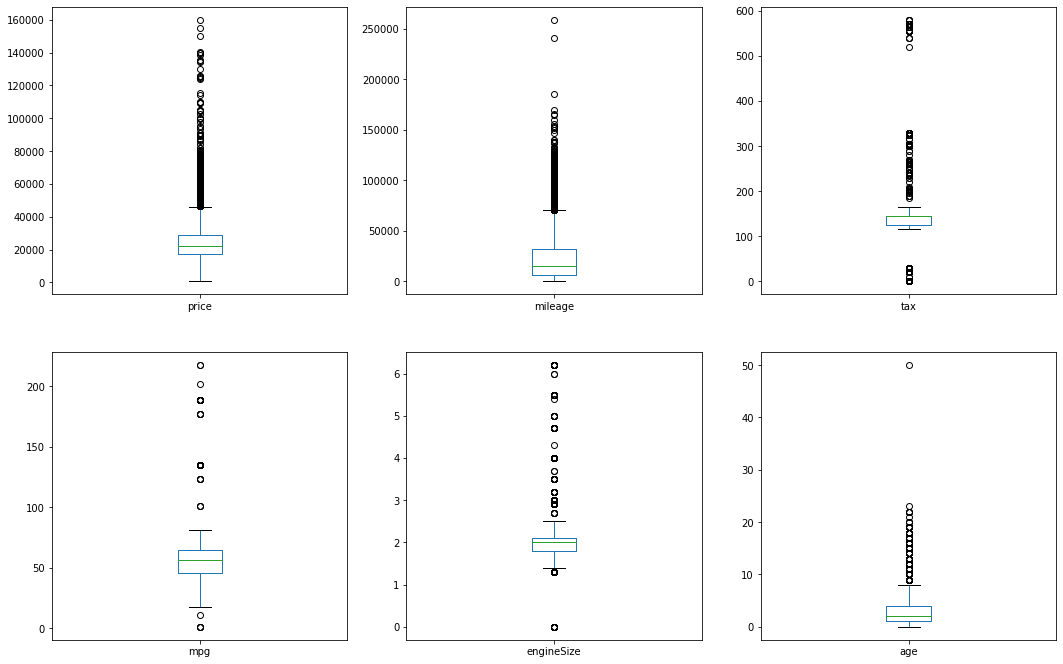

In [ ]:
plt.figure(figsize=(18, 18))
for n, col in enumerate(numeric_features, start=1):
    data[col].plot.box(ax=plt.subplot(3, 3, n))

Come possiamo notare, tutte le feature contengono diversi outliers. In alcune, questi valori sono ben distribuiti, mentre in altre, ossia age e mileage, sono presenti pochi outliers notevolmente distanti da tutti gli altri valori. Si procede perciò alla rimozione delle seguenti righe:

In [ ]:
data = data.loc[(data.age < 40) & (data.mileage < 200000),:]

Verifichiamo di nuovo il box-plot delle sopracitate feature, così da mostrare la differenza di omogeneità degli outliers.

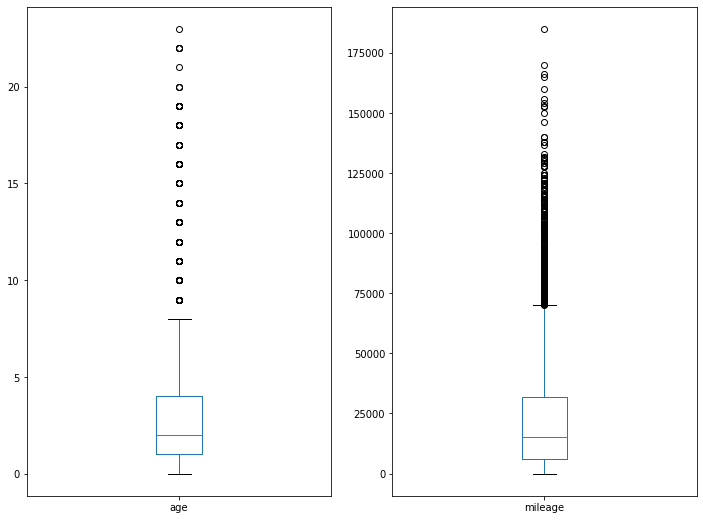

In [ ]:
plt.figure(figsize=(12, 9))
data.age.plot.box(ax=plt.subplot(1, 2, 1))
data.mileage.plot.box(ax=plt.subplot(1, 2, 2))


Passando alle feature categoriche, possiamo osservarne il numero di valori distinti per ciascuna di esse.

In [ ]:
for feature in categoric_features:
  print("Count of unique values of feature " + feature + " : {}".format(data.loc[:,feature].nunique()))

Count of unique values of feature model : 27
Count of unique values of feature transmission : 4
Count of unique values of feature fuelType : 4


Notiamo dunque che sia la trasmissione che il tipo di carburante utilizzato dai mezzi analizzati hanno scarsa variabilità.

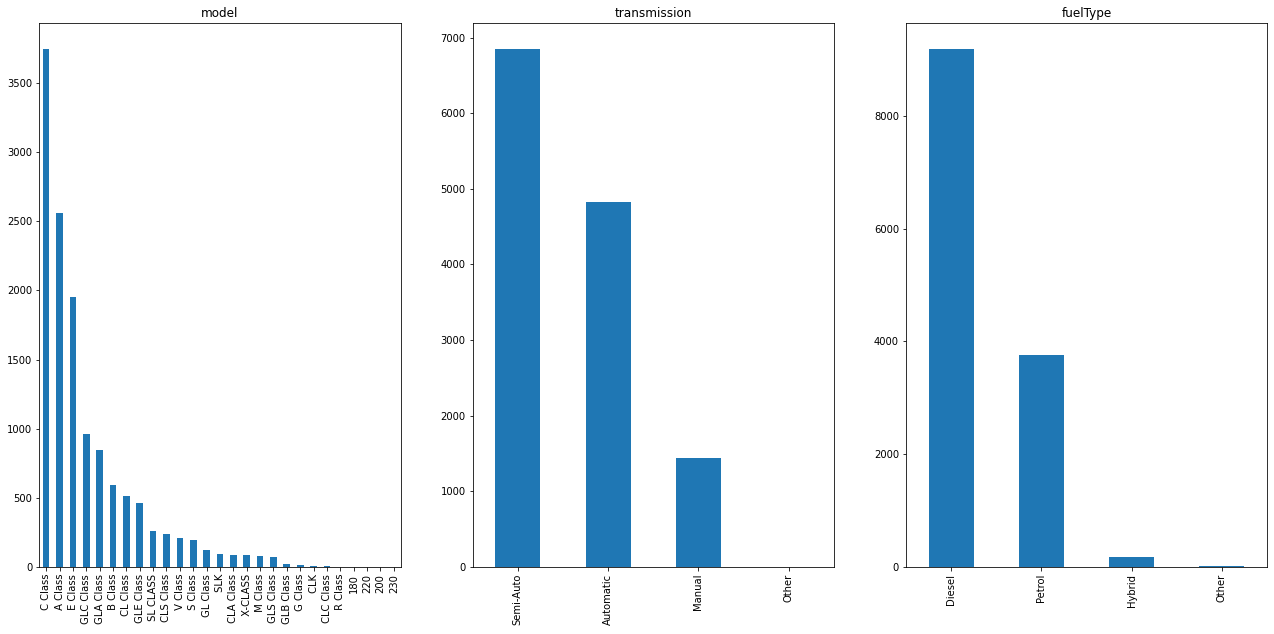

In [ ]:
plt.figure(figsize=(22, 10))
for n, col in enumerate(categoric_features, start=1):
    data[col].value_counts().plot.bar(ax=plt.subplot(1, 3, n))
    plt.title(col)

Da questi grafici notiamo il modello più presente sul mercato, ossia il Classe C. Notiamo inoltre che sono presenti alcuni veicoli con una trasmissione e tipo di carburante definiti come *Other*.
Per quanto riguarda la prima feature, i record potrebbero riferirsi ad una trasmissione Continuously Variable Transmission (CVT), ossia una trasmissione per certi versi simile ad una automatica.

In [ ]:
otherCars = data.loc[data.transmission == "Other"];
print(otherCars);
print("Numero di veicoli: {}".format(len(otherCars)));

            model    price transmission  mileage  ...  tax   mpg  engineSize  age
9650    GLA Class  18700.0        Other    30895  ...  125  56.5         0.0    4
12762         SLK  12995.0        Other    39000  ...  150  56.5         2.1    5

[2 rows x 9 columns]
Numero di veicoli: 2


Facendo una ricerca si scopre che nessuno dei due modelli riportati sono mai state equipaggiate con quella trasmissione; si decide quindi di rimuovere i due record.
Passando al tipo di carburante, il valore other potrebbe riferirsi ad automobili elettriche, sempre più popolari, oppure a modelli alimentati ad idrogeno, molto meno popolari nel mercato odierno.

In [ ]:
otherCars = data.loc[data.fuelType == "Other"];
print(otherCars);
print("Numero di veicoli: {}".format(len(otherCars)));

            model    price transmission  mileage  ...  tax    mpg  engineSize  age
9650    GLA Class  18700.0        Other    30895  ...  125   56.5         0.0    4
11740   GLE Class  31990.0    Automatic    46000  ...    0   76.4         3.0    4
12095     C Class  13850.0    Automatic    77814  ...    0  134.5         2.0    4
12184     C Class  17400.0    Automatic    52897  ...    0  134.5         2.0    3
12270     C Class  16000.0    Automatic    54011  ...    0  134.5         2.0    3
12389     C Class  15000.0    Automatic    53400  ...    0  134.5         2.0    5
12894     C Class  40999.0    Automatic      400  ...  135  217.3         2.0    0

[7 rows x 9 columns]
Numero di veicoli: 7


Anche in questo caso, le auto ottenute non sono modelli elettrici o ad idrogeno, quindi andiamo ad eliminare anche questi 7 record.

In [ ]:
data = data.loc[(data.transmission != "Other") & (data.fuelType != "Other"),:]
data.transmission.cat.remove_categories(removals=["Other"],inplace=True)
data.fuelType.cat.remove_categories(removals=["Other"],inplace=True)

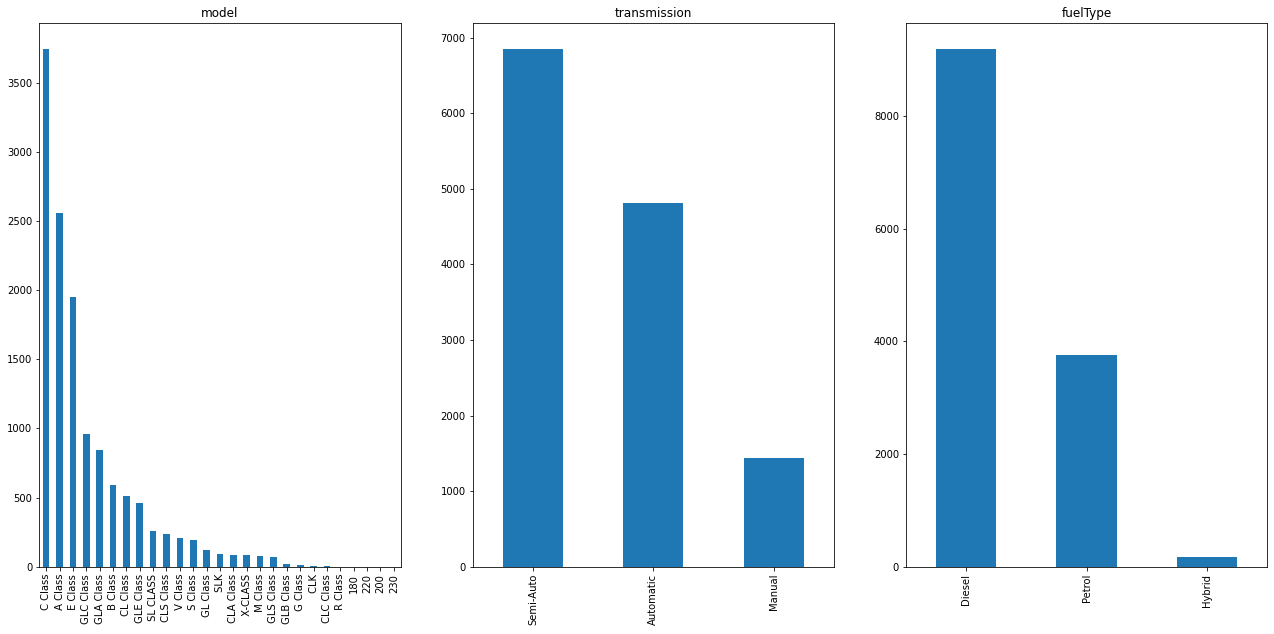

In [ ]:
plt.figure(figsize=(22, 10))
for n, col in enumerate(categoric_features, start=1):
    data[col].value_counts().plot.bar(ax=plt.subplot(1, 3, n))
    plt.title(col)

###Correlazione tra coppie di feature

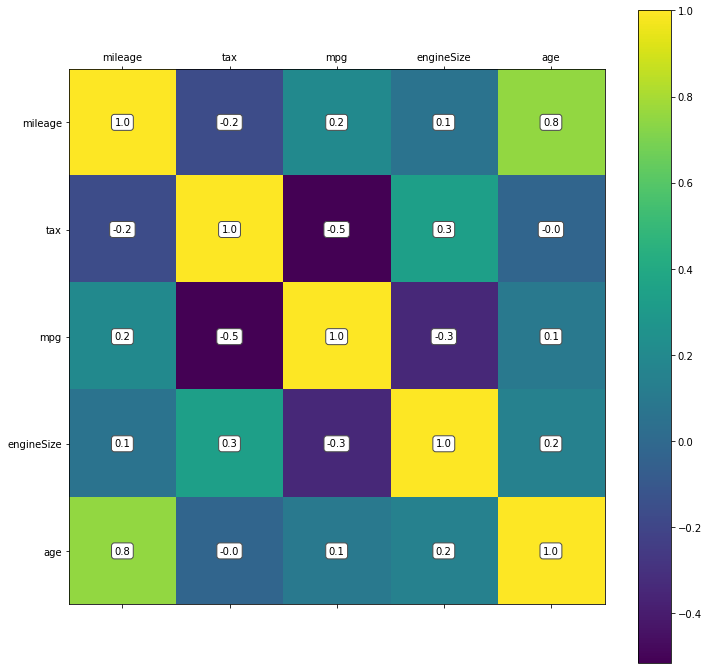

In [ ]:
corr = data.drop(columns=["price"]).corr()

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.matshow(corr,cmap="viridis")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);
fig.colorbar(im);
for (i, j), z in np.ndenumerate(corr):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.show();

Questo grafico mostra l'indice di correlazione di Pearson (quindi compreso tra -1 e 1) tra le coppie di feature numeriche.

* Tra prezzo della tassa e miglia per gallone troviamo una correlazione negativa: questo è dovuto probabilmente al fatto che un'auto poco efficiente nell'uso di carburante produrrà anche più anidride carbonica, facendo aumentare così la sopracitata tassa.
* Altra correlazione, sempre negativa, è quella che intercorre tra miglia percorse ed età del mezzo; risulta infatti ovvio che, più un auto è recente e meno miglia avrà percorso.
* Possiamo notare una lieve correlazione tra dimensione del motore e miglia per gallone, indicando che un motore più potente porti solitamente a consumi più elevati ed una efficienza ridotta.

##Parte 2 - Data Preprocessing

Per prima cosa, andiamo ad estrarre la variabile dipendente da predire dal resto dei dati. Il prezzo da calcolare, inoltre, viene convertito in migliaia di sterline, così da mantenere i coefficienti di regressione più bassi.

In [ ]:
y = data["price"];
X = data.drop(columns=["price"]);
numeric_features.remove("price")

###Utilizzo feature categoriche
Per poter utilizzare le variabili categoriche nei modelli che vogliamo costruire, verrà utilizzata la tecnica chiamata **One Hot Encoding**.
Questo meccanismo trasforma tali feature in feature numeriche, così da poterle utilizzare nella creazione dei modelli di regressione.
Per poter selezionare le sole colonne categoriche ed applicare l'encoding, viene inoltre utilizzato un **ColumnTransformer**; esso ci permetterà in seguito di standardizzare le sole feature numeriche.

###Standardizzazione
Per quanto riguarda la standardizzazione delle feature numeriche, considerando la differenza delle scale di valore di esse, possiamo ipotizzare che il suo utilizzo migliori i risultati notevolmente. Per dimostrare ciò, verranno creati due modelli di regressione lineare semplice, utlizzando solo nel primo caso uno StandardScaler; questi modelli verranno confrontati mediante l'utilizzo delle tre tecniche principali di valutazione di modelli di regressione.

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler();

def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true));

def print_eval(X, y, model):
    actual_printing(y,model.predict(X))

def print_eval_scaled(X, y, model):
    preds = model.predict(X)
    unscaled_preds = y_scaler.inverse_transform(preds);
    unscaled_y = y_scaler.inverse_transform(y);
    actual_printing(unscaled_y,unscaled_preds)

def actual_printing(y,preds):
    print("   Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("       Relative error: {:.5%}".format(relative_error(y, preds)))
    print("R-squared coefficient: {:.5}".format(r2_score(y, preds)))

def print_param_eval(gridSearch):
    print("\nDettagli parametri GridSearch:")
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', 100):  
      display(pd.DataFrame(gridSearch.cv_results_).sort_values("mean_test_score", ascending=False).head(5)[gsParams])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [ ]:
scaled_y = y_scaler.fit_transform(y.values[:, None]).ravel();
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categorical", OneHotEncoder(), categoric_features)
    ])),
    ("linreg" , LinearRegression())
])
model.fit(X,scaled_y)
print_eval_scaled(X,scaled_y,model)

   Mean squared error: 3.1344e+07
       Relative error: 16.98865%
R-squared coefficient: 0.77654


In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("categorical", OneHotEncoder(), categoric_features)
    ])),
    ("linreg" , LinearRegression())
])
model.fit(X,y)
print_eval(X,y,model)

   Mean squared error: 8.2825e+07
       Relative error: 29.84064%
R-squared coefficient: 0.4095


Come possiamo notare, benchè sia stato utilizzato solo un modello lineare, il guadagno in termini di accuratezza risulta essere considerevole.

###Individuazione feature più rilevanti

Per rilevare le feature più rilevanti nel problema analizzato, verrà creato un modello di regressione mediante Lasso, che utilizza una regolarizzazione di tipo l1.

In [ ]:
scaled_y = y_scaler.fit_transform(y.values[:, None]).ravel();
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categorical", OneHotEncoder(), categoric_features)
    ])),
    ("reg" , Lasso(alpha=0.001))
])
model.fit(X,scaled_y)
coefs = model.named_steps["reg"].coef_;
enc_categ_features = model.named_steps["preproc"].named_transformers_['categorical'].get_feature_names()
labels = np.concatenate([numeric_features, enc_categ_features]);
print(pd.Series(data=coefs,index=labels))
print_eval_scaled(X,scaled_y,model)



mileage         -0.219173
tax             -0.099752
mpg             -0.216720
engineSize       0.453992
age             -0.395023
x0_ A Class     -0.068753
x0_ B Class     -0.269874
x0_ C Class     -0.122150
x0_ CL Class    -0.128739
x0_ CLA Class   -0.000000
x0_ CLC Class    0.000000
x0_ CLK          0.000000
x0_ CLS Class   -0.093793
x0_ E Class     -0.000000
x0_ G Class      3.702628
x0_ GL Class    -0.000000
x0_ GLA Class   -0.250618
x0_ GLB Class    0.000000
x0_ GLC Class    0.259132
x0_ GLE Class    0.469727
x0_ GLS Class    0.554485
x0_ M Class      0.000000
x0_ R Class      0.000000
x0_ S Class      0.698237
x0_ SL CLASS    -0.009897
x0_ SLK          0.050062
x0_ V Class      0.286140
x0_ X-CLASS     -0.192113
x0_180           0.000000
x0_200          -0.000000
x0_220          -0.000000
x0_230           0.000000
x1_Automatic     0.000000
x1_Manual       -0.175762
x1_Semi-Auto     0.000981
x2_Diesel       -0.118007
x2_Hybrid        0.816707
x2_Petrol        0.000000
dtype: float

Osservando i coefficienti di regressione associati alle relative variabili di input, possiamo vedere che diversi di loro sono stati annullati, non perdendo nulla in accuratezza. Notiamo inoltre che per la feature transmission solo un coefficiente è non nullo: questo ci fa capire che il cambio dell'automobile non incida particolarmente sul suo prezzo.

In [ ]:
print(pd.Series(data=coefs,index=labels).abs().sort_values(ascending=False).head(5))

x0_ G Class      3.702628
x2_Hybrid        0.816707
x0_ S Class      0.698237
x0_ GLS Class    0.554485
x0_ GLE Class    0.469727
dtype: float64


La lista dei coefficienti più influenti ci fa intedere quanto il modello del veicolo influisca sul prezzo di quest'ultimo. Risulta chiaro che, nonostante tutto, un'automobile di lusso (come il Mercedes G Class) abbia un prezzo base più alto di, ad esempio, un'utilitaria.

###Hold Out
Viene in seguito diviso il dataset in training e validation set, con una divisione di 2/3 ed 1/3 rispettivamente.

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=1/3,random_state=42);
#X_transformer = ColumnTransformer([
#        ("numeric" , StandardScaler(), numeric_features),
#        ("categoric" , OneHotEncoder(),  categoric_features)
#    ]);

#X_transformer.fit(X)
y_scaler.fit(y.values[:,None])

#X_train = X_transformer.transform(X_train)
#X_val = X_transformer.transform(X_val)

y_train = y_scaler.transform(y_train.values[:,None]).ravel()
y_val = y_scaler.transform(y_val.values[:,None]).ravel()

##Parte 3 - Modellazione

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

gsParams = ["rank_test_score","mean_test_score","params"]

Vengono in seguito creati diversi modelli di regressione.

###Regressione Polinomiale

Partiamo con la creazone di un modello di regressione polinomiale senza regolarizzazione, facendo una grid search per il grado migliore a cui elevare i dati.

In [ ]:
numeric_preproc = Pipeline([
    ("std",StandardScaler()),
    ("poly",PolynomialFeatures(include_bias=False))
]);

model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", numeric_preproc, numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , LinearRegression())
])
grid = {
    "preproc__numeric__poly__degree": [2, 3, 4]
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print_param_eval(gs)

   Mean squared error: 2.3825e+07
       Relative error: 11.65015%
R-squared coefficient: 0.84339

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
0,1,0.852014,{'preproc__numeric__poly__degree': 2}
1,2,0.842893,{'preproc__numeric__poly__degree': 3}
2,3,0.674819,{'preproc__numeric__poly__degree': 4}


###Regressione Ridge

Proviamo ad applicare un modello di regressione lineare con regolarizzazione

In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , Ridge())
])
grid = {
    "reg__alpha":[0.01,0.1,1,10]
}
kf = KFold(4, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print_param_eval(gs)

   Mean squared error: 3.7266e+07
       Relative error: 17.44905%
R-squared coefficient: 0.75504

Dettagli parametri GridSearch:
   rank_test_score  mean_test_score                params
0                1         0.782540  {'reg__alpha': 0.01}
1                2         0.782462   {'reg__alpha': 0.1}
2                3         0.781721     {'reg__alpha': 1}
3                4         0.773634    {'reg__alpha': 10}


In questo caso notiamo che, tranne con alpha molto grande (e quindi con molta regolarizzazione), lo score rimanga più o meno lo stesso.

###Regressione Ridge Polinomiale
Testiamo di nuovo la regressione ridge, ma in questo caso aumentiamo la dimensionalità

In [ ]:
numeric_preproc = Pipeline([
    ("std",StandardScaler()),
    ("poly",PolynomialFeatures(include_bias=False))
]);

model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", numeric_preproc, numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , Ridge())
])
grid = {
    "preproc__numeric__poly__degree": [2, 3, 4],
    "reg__alpha":[0.01,0.1,1,10]
}
kf = KFold(4, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print_param_eval(gs)

   Mean squared error: 2.3825e+07
       Relative error: 11.64999%
R-squared coefficient: 0.84339

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
0,1,0.851355,"{'preproc__numeric__poly__degree': 2, 'reg__alpha': 0.01}"
1,2,0.851344,"{'preproc__numeric__poly__degree': 2, 'reg__alpha': 0.1}"
2,3,0.850906,"{'preproc__numeric__poly__degree': 2, 'reg__alpha': 1}"
3,4,0.845975,"{'preproc__numeric__poly__degree': 2, 'reg__alpha': 10}"
4,5,0.837739,"{'preproc__numeric__poly__degree': 3, 'reg__alpha': 0.01}"


Notiamo subito un grande miglioramento per quanto riguarda lo score, che ora si aggira sul 0.84. Nonostante ciò, tale score risulta essere simile a quello ottenuto senza regolarizzazione.

###Regressione Ridge Polinomiale (includendo feature categoriche polinomiali)

In questo caso, invece di elevare la dimensionalità delle sole feature numeriche, generiamo le feature polinomiali di tutte le colonne ottenute in seguito al preprocessing. 

In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("reg" , Ridge())
])
grid = {
    "reg__alpha":[0.01,0.1,1,10]
}
kf = KFold(4, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print_param_eval(gs)

   Mean squared error: 1.4889e+07
       Relative error: 10.10878%
R-squared coefficient: 0.90213

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
3,1,0.894426,{'reg__alpha': 10}
2,2,0.893167,{'reg__alpha': 1}
1,3,0.891477,{'reg__alpha': 0.1}
0,4,0.891461,{'reg__alpha': 0.01}


Notiamo un ulteriore miglioramento rispetto al modello precedente; in questo caso viene preferita una regolarizzazione più elevata.

###Regressione Lasso

In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , Lasso())
])
grid = {
    "reg__alpha":[0.01,0.1,1,10]
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print(gs.best_params_)

   Mean squared error: 4.5563e+07
       Relative error: 18.23235%
R-squared coefficient: 0.7005
{'reg__alpha': 0.01}


###Regressione Lasso polinomiale
Testiamo ora la regressione Lasso utilizzando anche le feature polinomiali generate partendo dalle sole variabili numeriche.

In [ ]:
numeric_preproc = Pipeline([
    ("std",StandardScaler()),
    ("poly",PolynomialFeatures(include_bias=False))
]);

model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", numeric_preproc, numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , Lasso())
])
grid = {
    "preproc__numeric__poly__degree": [2, 3, 4],
    "reg__alpha":[0.01,0.1,1,10],
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print_param_eval(gs)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.91571002572186, tolerance: 0.5486416389008448
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160.55077290992676, tolerance: 0.5553808828451668
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 258.1931474496295, tolerance: 0.5696096229296246
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.64590

   Mean squared error: 2.6897e+07
       Relative error: 12.19569%
R-squared coefficient: 0.8232

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
4,1,0.823918,"{'preproc__numeric__poly__degree': 3, 'reg__alpha': 0.01}"
8,2,0.814874,"{'preproc__numeric__poly__degree': 4, 'reg__alpha': 0.01}"
0,3,0.810928,"{'preproc__numeric__poly__degree': 2, 'reg__alpha': 0.01}"
5,4,0.733577,"{'preproc__numeric__poly__degree': 3, 'reg__alpha': 0.1}"
1,5,0.733304,"{'preproc__numeric__poly__degree': 2, 'reg__alpha': 0.1}"


Come nel caso della regressione Ridge, anche in questo caso l'utilizzo delle feature polinomiali porta ad un sensibile miglioramento dello score.

###Regressione Lasso Polinomiale (includendo feature categoriche polinomiali)

In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("poly",PolynomialFeatures(include_bias=False)),
    ("reg" , Lasso())
])
grid = {
    "reg__alpha":[0.01,0.1,1,10],
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print_param_eval(gs)

   Mean squared error: 2.5568e+07
       Relative error: 12.07877%
R-squared coefficient: 0.83193

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
0,1,0.828521,{'reg__alpha': 0.01}
1,2,0.733304,{'reg__alpha': 0.1}
2,3,0.042982,{'reg__alpha': 1}
3,4,-0.000108,{'reg__alpha': 10}


###Elastic Net

In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , ElasticNet())
])
grid = {
    "reg__alpha":[0.01,0.1,1,10],
    "reg__l1_ratio": [0.1, 0.2, 0.3]
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print_param_eval(gs)

   Mean squared error: 4.1879e+07
       Relative error: 17.60562%
R-squared coefficient: 0.72472

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
0,1,0.757148,"{'reg__alpha': 0.01, 'reg__l1_ratio': 0.1}"
1,2,0.753378,"{'reg__alpha': 0.01, 'reg__l1_ratio': 0.2}"
2,3,0.749976,"{'reg__alpha': 0.01, 'reg__l1_ratio': 0.3}"
3,4,0.709981,"{'reg__alpha': 0.1, 'reg__l1_ratio': 0.1}"
4,5,0.697944,"{'reg__alpha': 0.1, 'reg__l1_ratio': 0.2}"


###Elastic Net polinomiale

In [ ]:
numeric_preproc = Pipeline([
    ("std",StandardScaler()),
    ("poly",PolynomialFeatures(include_bias=False))
]);

model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", numeric_preproc, numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , ElasticNet())
])
grid = {
    "preproc__numeric__poly__degree": [2, 3, 4],
    "reg__alpha":[0.01,0.1,1,10],
    "reg__l1_ratio": [0.1, 0.2, 0.3]
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print_param_eval(gs)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.609922359521306, tolerance: 0.5486416389008448
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.955127471077162, tolerance: 0.5553808828451668
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7071188631545056, tolerance: 0.5696096229296246
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.3349

   Mean squared error: 2.3024e+07
       Relative error: 11.76037%
R-squared coefficient: 0.84866

Dettagli parametri GridSearch:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 429.0641071094372, tolerance: 0.8368258700431763
  positive)


,rank_test_score,mean_test_score,params
25,1,0.839297,"{'preproc__numeric__poly__degree': 4, 'reg__alpha': 0.01, 'reg__l1_ratio': 0.2}"
26,2,0.838563,"{'preproc__numeric__poly__degree': 4, 'reg__alpha': 0.01, 'reg__l1_ratio': 0.3}"
24,3,0.837798,"{'preproc__numeric__poly__degree': 4, 'reg__alpha': 0.01, 'reg__l1_ratio': 0.1}"
13,4,0.836987,"{'preproc__numeric__poly__degree': 3, 'reg__alpha': 0.01, 'reg__l1_ratio': 0.2}"
14,5,0.836540,"{'preproc__numeric__poly__degree': 3, 'reg__alpha': 0.01, 'reg__l1_ratio': 0.3}"


###Elastic Net polinomiale (includendo feature categoriche polinomiali)

In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("poly",PolynomialFeatures(include_bias=False)),
    ("reg" , ElasticNet())
])
grid = {
    "reg__alpha":[0.01,0.1,1,10],
    "reg__l1_ratio": [0.1, 0.2, 0.3]
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print_param_eval(gs)

   Mean squared error: 1.7137e+07
       Relative error: 10.23014%
R-squared coefficient: 0.88735

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
0,1,0.880275,"{'reg__alpha': 0.01, 'reg__l1_ratio': 0.1}"
1,2,0.873757,"{'reg__alpha': 0.01, 'reg__l1_ratio': 0.2}"
2,3,0.867150,"{'reg__alpha': 0.01, 'reg__l1_ratio': 0.3}"
3,4,0.814014,"{'reg__alpha': 0.1, 'reg__l1_ratio': 0.1}"
4,5,0.795209,"{'reg__alpha': 0.1, 'reg__l1_ratio': 0.2}"


###Kernel Ridge

In questa modellazione verranno valutate due funzioni kernel:

*   Kernel Polinomiale
*   Radial Basis Function

In base alla funzione kernel verranno verificati gli iperparametri alpha (poly) e gamma (rbf).


In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , KernelRidge(kernel="poly"))
])
grid = [
    {
      "reg__degree":[2,3,4],
      "reg__alpha":[0.01,0.1,1,10]
    }
]
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print_param_eval(gs)

   Mean squared error: 1.3041e+07
       Relative error: 8.90446%
R-squared coefficient: 0.91428

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
5,1,0.912347,"{'reg__alpha': 0.1, 'reg__degree': 4}"
4,2,0.906572,"{'reg__alpha': 0.1, 'reg__degree': 3}"
8,3,0.902997,"{'reg__alpha': 1, 'reg__degree': 4}"
0,4,0.894397,"{'reg__alpha': 0.01, 'reg__degree': 2}"
3,5,0.892275,"{'reg__alpha': 0.1, 'reg__degree': 2}"


La creazione del modello kernel ridge ha richiesto un tempo considerevolmente più alto rispetto agli altri modelli. Questo è dovuto all'elevato numero di istanze di training e validazione, in quanto la complessità del calcolo di un modello mediante funzioni kernel risulta essere il quadrato delle istanze.
Il risultato però è un modello molto accurato, che ottiene uno score di 0.91.

Testiamo di nuovo la Kernel Ridge Regression, ma questa volta proviamo ad utilizzare un kernel di tipo RBF.

In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , KernelRidge(kernel="rbf"))
])
grid = {
      "reg__gamma":[0.01,0.1,1,10],
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print_param_eval(gs)

   Mean squared error: 1.1545e+07
       Relative error: 8.64967%
R-squared coefficient: 0.92411

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
1,1,0.903889,{'reg__gamma': 0.1}
0,2,0.840827,{'reg__gamma': 0.01}
2,3,0.832079,{'reg__gamma': 1}
3,4,0.613597,{'reg__gamma': 10}


Confrontando il modello che utilizza RBF con quello che fa uso di kernel polinomiale, notiamo che il primo risulta essere leggermente più accurato. 

###Decision Tree Regressor

Come ultimo, testiamo un modello Decision Tree Regressor

In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_features),
        ("categoric", OneHotEncoder(handle_unknown="ignore"), categoric_features)
    ])),
    ("reg" , DecisionTreeRegressor())
])
grid = {
    "reg__max_depth": [3, 5, 10, None],
    "reg__min_samples_split": [2, 0.02, 0.05, 0.1]
}

kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf, refit=True)
gs.fit(X_train, y_train)
print_eval_scaled(X_val,y_val,gs)
print_param_eval(gs)

   Mean squared error: 1.3097e+07
       Relative error: 8.64541%
R-squared coefficient: 0.91391

Dettagli parametri GridSearch:


,rank_test_score,mean_test_score,params
12,1,0.874773,"{'reg__max_depth': None, 'reg__min_samples_split': 2}"
8,2,0.870725,"{'reg__max_depth': 10, 'reg__min_samples_split': 2}"
13,3,0.830026,"{'reg__max_depth': None, 'reg__min_samples_split': 0.02}"
9,4,0.827448,"{'reg__max_depth': 10, 'reg__min_samples_split': 0.02}"
14,5,0.797481,"{'reg__max_depth': None, 'reg__min_samples_split': 0.05}"


In [ ]:
gs.best_estimator_[1].feature_importances_

array([3.36617635e-01, 2.70410652e-02, 1.40314382e-01, 3.16144973e-01,
       7.80257698e-02, 2.67190194e-02, 3.94253706e-03, 4.11588219e-03,
       9.71001140e-04, 2.12851104e-04, 9.65444279e-08, 0.00000000e+00,
       1.34458359e-03, 2.95583763e-03, 2.09749627e-03, 6.86784096e-04,
       6.40987136e-04, 1.91848474e-07, 1.07808730e-02, 1.51280873e-02,
       3.01080587e-03, 4.55652888e-05, 0.00000000e+00, 1.45281870e-02,
       5.99802556e-04, 6.49519410e-05, 3.41469206e-03, 4.46640699e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.12003079e-03,
       4.45449630e-03, 1.29534930e-03, 8.56867065e-04, 1.37624096e-04,
       1.72710884e-03])